We inspect the crosslinking algorithm using its debug output. By plotting bead chains alongside active and visited agents at various simulation times, we inspect the progression of candidate selection and bond formation within the defined constraint.

In [1]:
import sys

sys.path.append("../")

In [2]:
import json
from pathlib import Path
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from config import Config
from matplotlib.patches import Circle

In [16]:
gel_dir_path = Path(
    "/Users/r/Documents/work/icp/microgel/code/data/tests/new_crosslinking2"
)
debug_dir_path = gel_dir_path / "raw/debug/agents"
assert debug_dir_path.exists()
debug_paths = list(debug_dir_path.glob("*.json"))

In [5]:
def dict_to_df(data: dict[str, Any]) -> pd.DataFrame:
    df = pd.DataFrame(data)

In [6]:
debug_data = [json.loads(path.read_text()) for path in debug_paths]
debug_data = sorted(debug_data, key=lambda x: x["sim_time"])
list(debug_data[0].keys())

['sim_time',
 'all_bead_pos',
 'all_bead_ids',
 'all_agent_pos',
 'all_agent_ids',
 'active_agent_ids',
 'crosslinks',
 'all_agent_candidates',
 'visited_agent_candidates',
 'visited_bead_pair_lists',
 'visited_bead_pair_weights']

In [9]:
for data in debug_data:
    data["all_agent_pos"] = np.array(data["all_agent_pos"])
    data["all_bead_pos"] = np.array(data["all_bead_pos"])

    data["agent_id_to_index"] = {
        agent_id: i for i, agent_id in enumerate(data["all_agent_ids"])
    }
    data["bead_id_to_index"] = {
        bead_id: i for i, bead_id in enumerate(data["all_bead_ids"])
    }
    data["agent_color"] = np.array(
        [
            "red"
            if agent_id in data["visited_agent_candidates"]
            else ("blue" if agent_id in data["active_agent_ids"] else "grey")
            for agent_id in data["all_agent_ids"]
        ]
    )
    inactive_agent_ids = set(data["all_agent_ids"]) - set(data["active_agent_ids"])
    assert len(inactive_agent_ids.intersection(data["visited_agent_candidates"])) == 0
    assert len(inactive_agent_ids.intersection(data["all_agent_candidates"])) == 0

In [24]:
config = Config.from_file(gel_dir_path / "config.json")
np.shape(np.split(debug_data[0]["all_bead_pos"], config.n_chains))

(40, 8, 3)

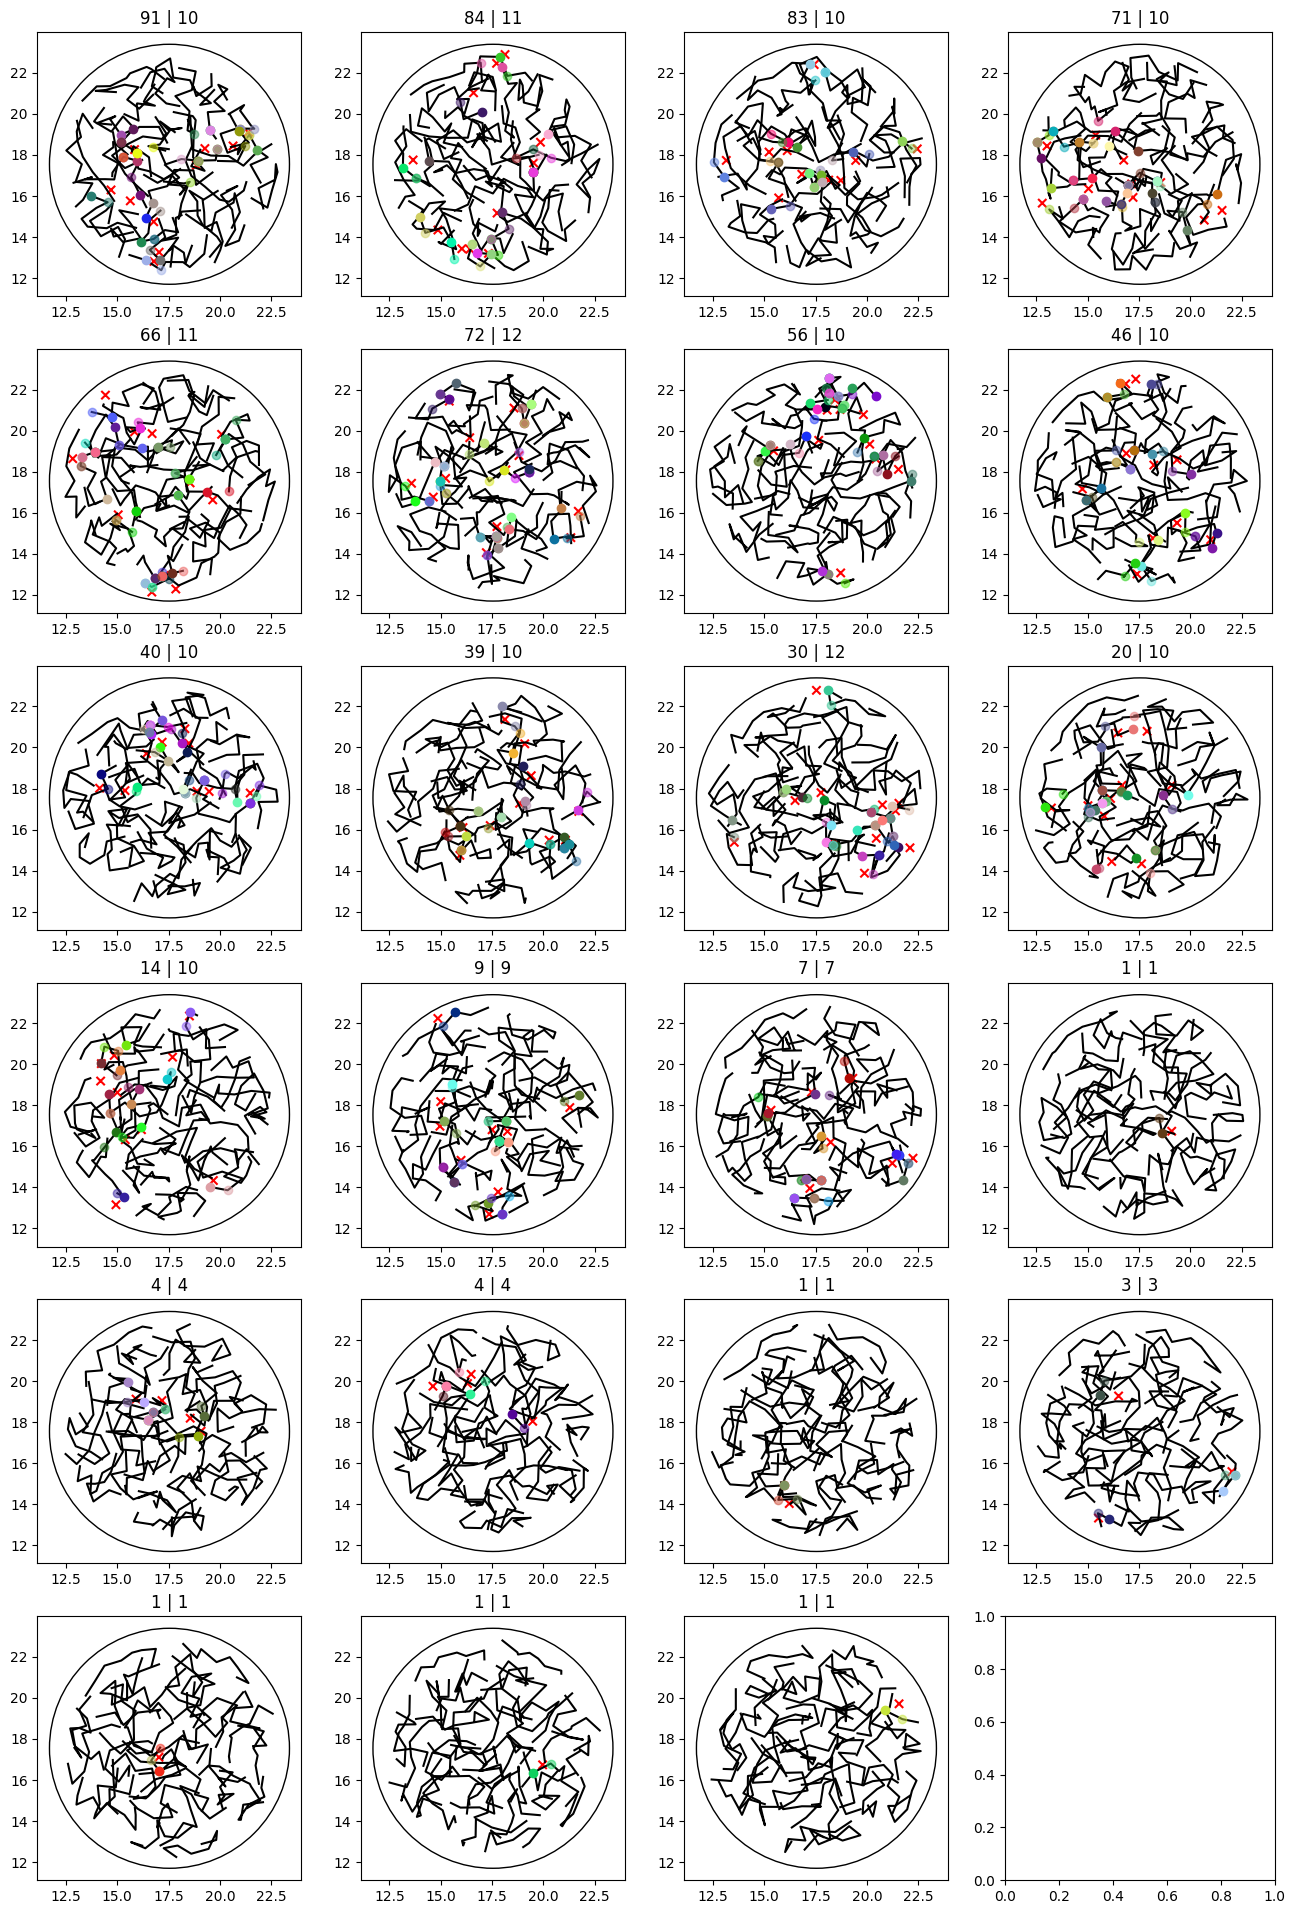

In [40]:
ncols = 4
nrows = len(debug_data) // ncols + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))
for i, data in enumerate(debug_data):
    ax = axs.flatten()[i]

    # plot all beads
    for beads in np.split(data["all_bead_pos"], config.n_chains):
        ax.plot(*beads[:, :2].T, "k-")

    # highlight chosen beads
    for bead_list in data["visited_bead_pair_lists"]:
        for b1_id, b2_id in bead_list:
            b1_idx, b2_idx = (
                data["bead_id_to_index"][b1_id],
                data["bead_id_to_index"][b2_id],
            )
            color = np.random.uniform(0, 1, 3)
            ax.plot(
                data["all_bead_pos"][b1_idx, 0],
                data["all_bead_pos"][b1_idx, 1],
                "o",
                alpha=0.5,
                color=color,
            )
            ax.plot(
                data["all_bead_pos"][b2_idx, 0],
                data["all_bead_pos"][b2_idx, 1],
                "o",
                # alpha=0.5,
                color=color,
            )

    # plot visited agents
    alpha = data["agent_color"].copy()
    alpha[alpha == "grey"] = 0.0
    alpha[alpha == "blue"] = 0.0
    alpha[alpha == "red"] = 1.0
    alpha = alpha.astype(float)
    ax.scatter(
        *data["all_agent_pos"][:, :2].T, c=data["agent_color"], marker="x", alpha=alpha
    )

    # plot constraint
    ax.add_patch(
        Circle(
            (config.initial_box_l / 2, config.initial_box_l / 2),
            config.constraint_radius,
            fill=False,
        )
    )

    ax.set_aspect("equal")
    n_agent_candidates = len(data["all_agent_candidates"])
    ax.set_title(f"{n_agent_candidates} | {len(data['visited_agent_candidates'])}")